# `elec-00`: EEG preprocessing
This lab implements EEG preprocessing using bandpass filtering and independent component analysis (ICA). ICA-based preprocessing will allow us to identify and remove noise signals due to eye-blinks. We'll use the [MNE](https://mne.tools/stable/index.html) Python package for visualization and analysis. If you don't have MNE installed, run the following line in your conda environment: `conda install -c conda-forge mne-base`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Load in raw data
Similar to fMRI, EEG data come in a variety of different file formats. We will use the Elektra Neuromag (fif) file format, typically associated with MEG data, as that is a commonly used data type in MNE. For loading different file formats into MNE, see this [tutorial](https://mne.tools/stable/auto_tutorials/io/index.html).

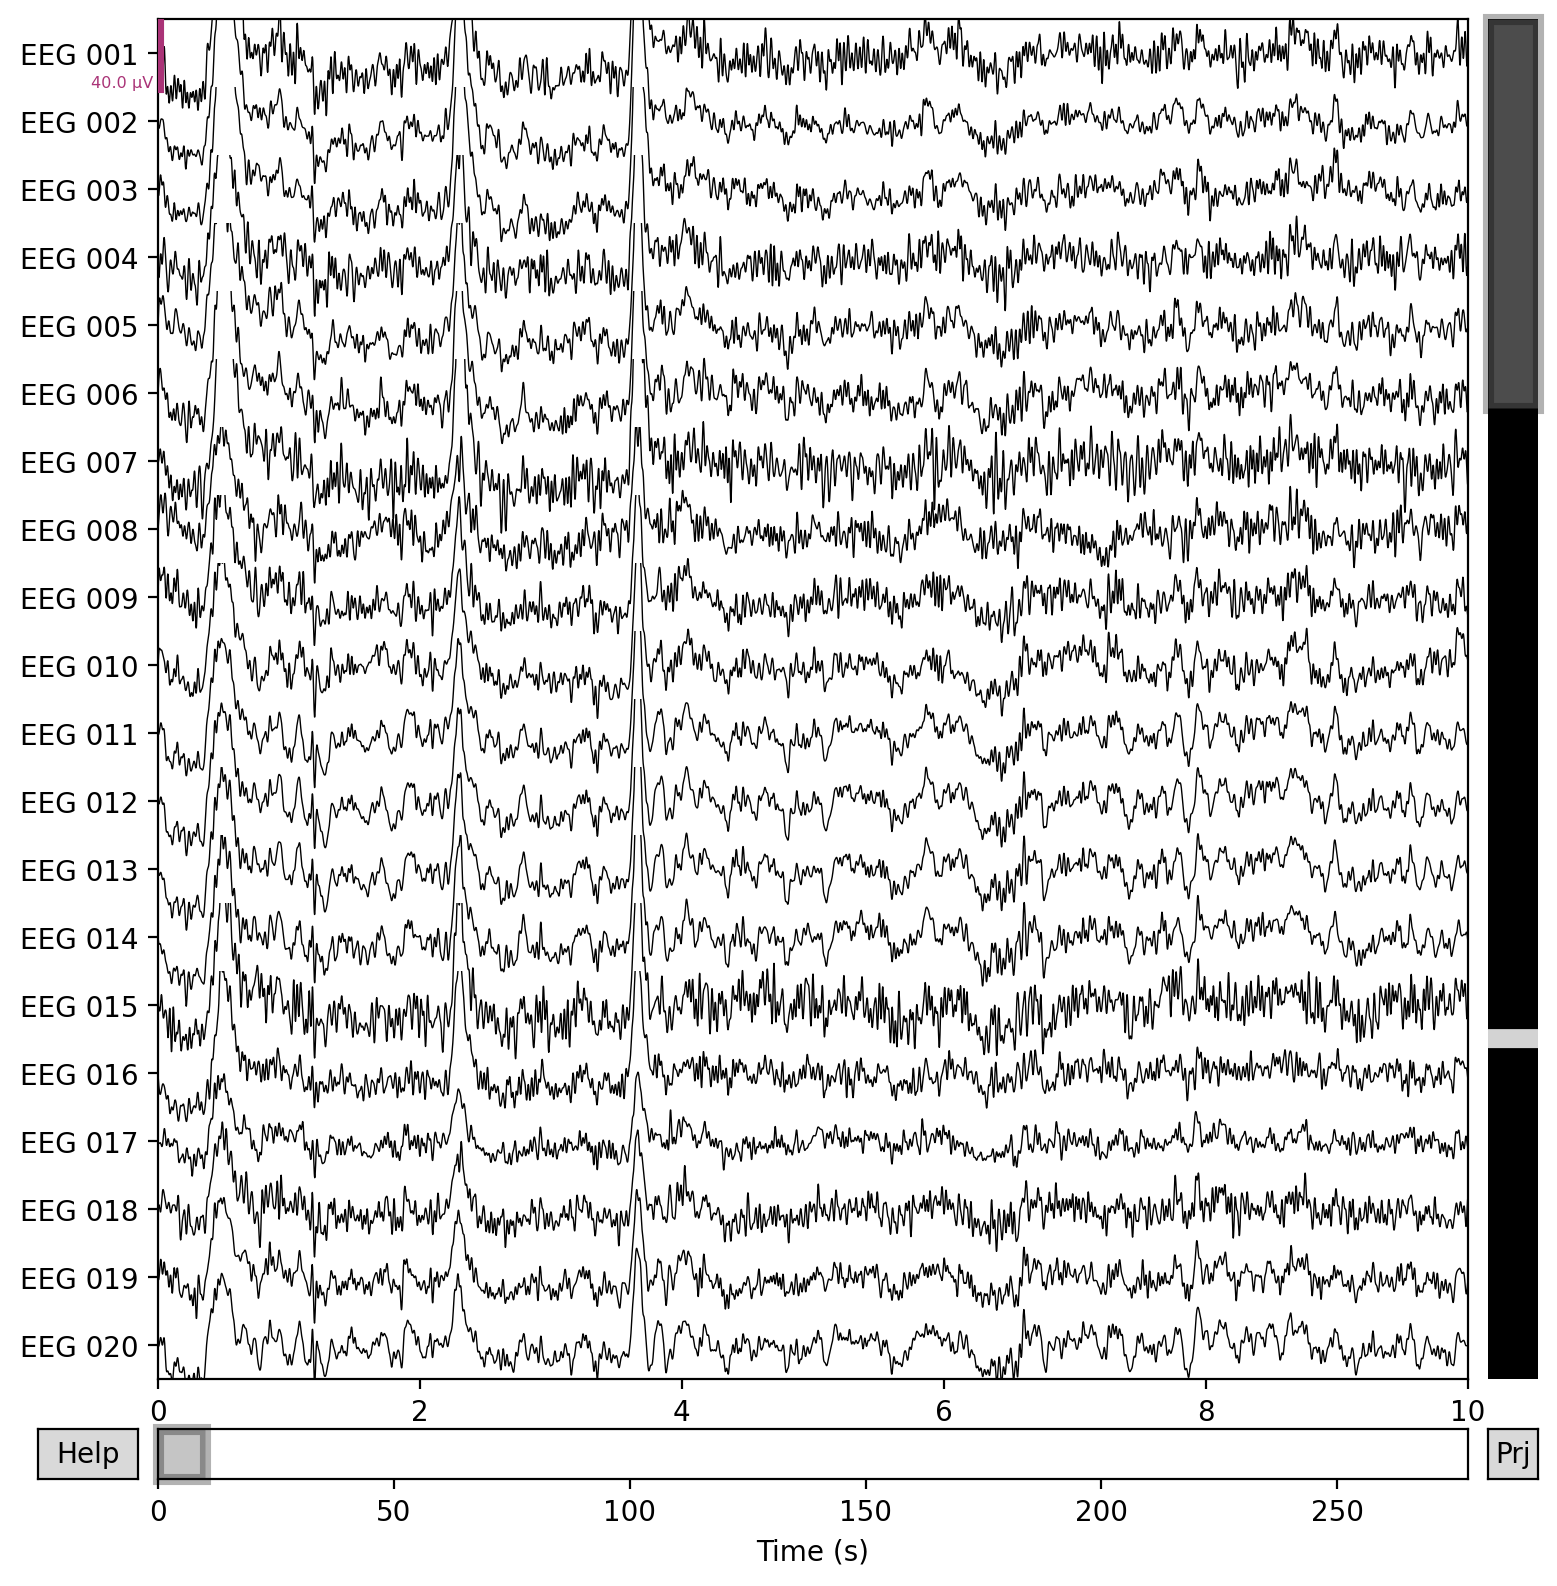

In [33]:
data_raw.plot()

In [2]:
from mne.io import read_raw

# Specify path to raw data
raw_fn = 'sub-01_task-audvis_raw.fif'

# Load raw data
data_raw = read_raw(raw_fn, preload=True, verbose=False)
print(data_raw)

<Raw | sub-01_task-audvis_raw.fif, 70 x 166800 (277.7 s), ~92.1 MB, data loaded>


### Visualizing the raw data
The `mne.io.Raw` class object is a very helpful data structure, containing the entire EEG recording and its corresponding metadata. The `.info` attribute allows us to easily inspect all of the metadata. For example, we can specify that channel `EEG 053` is a bad channel. Use `find_layout` from `mne.channels` and `plot_layout` from `mne.viz` to visualize the channel layout.

In [5]:
print(data_raw.info)

<Info | 20 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: STI 001, STI 002, STI 003, STI 004, STI 005, STI 006, STI 014, ...
 chs: 9 Stimulus, 60 EEG, 1 EOG
 custom_ref_applied: False
 description: acquisition (megacq) VectorView system at NMR-MGH
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172.2 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 70
 proj_id: 1 item (ndarray)
 proj_name: test
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off
 sfreq: 600.6 Hz
>


<Info | 20 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: STI 001, STI 002, STI 003, STI 004, STI 005, STI 006, STI 014, ...
 chs: 9 Stimulus, 60 EEG, 1 EOG
 custom_ref_applied: False
 description: acquisition (megacq) VectorView system at NMR-MGH
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172.2 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 70
 proj_id: 1 item (ndarray)
 proj_name: test
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off
 sfreq: 600.6 Hz
>


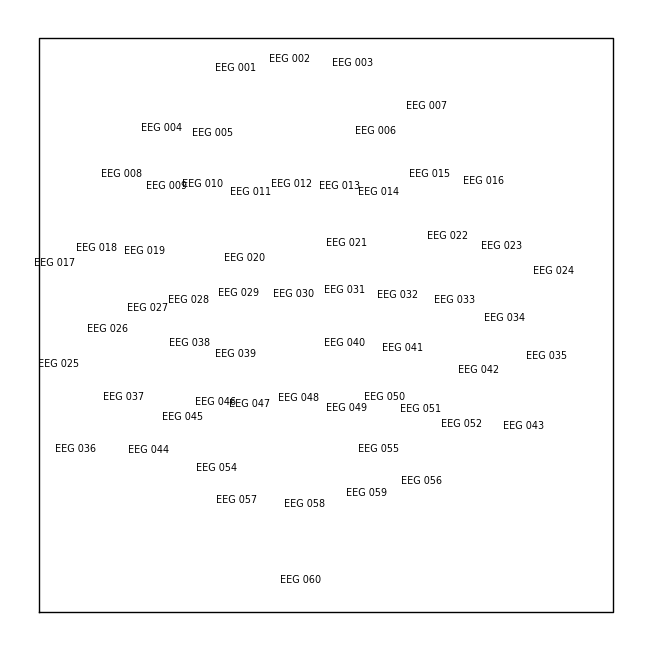

In [6]:
# Inspect metadata
print(data_raw.info)

# Designate bad channel
data_raw.info['bads'] = ['EEG 053']

# Visualize channel layout:
from mne.channels import find_layout
from mne.viz import plot_layout

layout = find_layout(data_raw.info)
plot_layout(layout);

We can interactively visualize the raw EEG data using `Raw` object's `.plot()` method. You may need to specify a `%matplotlib` magic command for interactive plotting (e.g. `%matplotlib osx` for Mac).

In [7]:
# Interactively plot raw data:
%matplotlib osx

data_raw.plot();

Using matplotlib as 2D backend.
Channels marked as bad:
['EEG 053']


We can also interactively visualize the standard (e.g. 10–20) channel layouts. Use `make_standard_montage` from `mne.channels` with the `'standard_1020'`) argument to create the standard montage. Use the montage's `.plot()` method (with `kind='3d'` or `kind='topomap'`) to visualize the channel layout.

In [20]:
# Create standard 1020 channel locations:
from mne.channels import make_standard_montage

ten_twenty_montage = make_standard_montage('standard_1020')
print(ten_twenty_montage)

# Plot standard electrode locations:
%matplotlib osx
fig = ten_twenty_montage.plot(kind='3d')
fig.gca().view_init(azim=70, elev=15)
ten_twenty_montage.plot(kind='topomap', show_names=False);

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 94 channels>
4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.
4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.


### Filtering

Filtering data can help remove high-frequency artifacts (e.g. EMG artifact) and low-frequency drifts, and notch filters at 50 Hz or 60 Hz help attenuate electrical line noise. Applying a high-pass filter at 0.1 Hz or 0.5 Hz to the continuous data is useful and recommended to minimize slow drifts. More conservative high-pass filters have the potential to [distort and bias EEG analysis](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4506207/). Use the `Raw` data's `.filter()` method to bandpass filter the EEG data between 0.5 and 40 Hz using the FIR method with zero phase. We'll use `pick_types` to specify only the EEG channels (e.g. excluding ocular channels, stimulus channels, etc). Name the output `data_filtered`.

In [34]:
data_filtered.plot();

Channels marked as bad:
['EEG 053']
Channels marked as bad:
['EEG 053']


In [11]:
from mne import pick_types

# Select EEG channels (excluding other channels)
picks = pick_types(data_raw.info, meg=False, eeg=True, eog=False, stim=False)

# Apply bandpass filter:
data_filtered = data_raw.filter(l_freq=0.5, h_freq=40.0, picks=picks, phase='zero')

Filtering a subset of channels. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3965 samples (6.602 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


In [13]:
%matplotlib osx
data_filtered.plot();

Channels marked as bad:
['EEG 053']


### Independent component analysis (ICA)

There are many sources of artifact in EEG data, including head motion, muscle tension, recording drift, and channel pops. Perhaps the most common source of artifact is eyeblink. Oculomotor activity causes large deflections in the EEG recording (with decreasing magnitude in channels further from the eyes). There are a number of methods for removing eyeblinks, including amplitude rejection, signal space projection (SSP), and independent component analysis (ICA). ICA finds directions in the feature space corresponding to projections with high non-Gaussianity. We thus obtain a decomposition into independent components, and the artifact's contribution is typically localized in only a small number of components. These components must be correctly identified and removed. More complete information about the theory behind ICA and its application with MNE can be found [here](https://mne.tools/stable/auto_tutorials/preprocessing/plot_40_artifact_correction_ica.html). Initialize `ICA` from `mne.preprocessing` with `n_components` (the number PCs retained prior to ICA) set to 25, using `method='fastica'`. Use `pick_types` to specify the EEG channels, then use the ICA object's `.fit()` (with `decim=3`) to estimate the ICs from the EEG data.

In [14]:
from mne.preprocessing import ICA

# Define parameters for ICA
n_components = 25
method = 'fastica'
decim = 3 

# Initialize MNE's ICA object:
ica = ICA(n_components=n_components, method=method, random_state=1)

# Fit ICA to filtered data:
picks = pick_types(data_raw.info, meg=False, eeg=True, eog=False, stim=False)
ica.fit(data_filtered, decim=decim, picks=picks)
print(ica)

Fitting ICA to data using 59 channels (please be patient, this may take a while)
Selecting by number: 25 components
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. In

We can visualize the scalp topography of each component to identify artifactual components. Use the fitted ICA object's `.plot_components()` method to plot the scalp topography of the ICs.

In [22]:
# Plot ICA components:
ica.plot_components();

MNE also has some nice functions for visually exploring features of each component. Try using the fitted ICA object's `.plot_properties()` method to visualize some potentially problematic ICs.

In [18]:
# Visualize IC properties:
ica.plot_properties(data_filtered, picks=17, psd_args={'fmax': 40.});

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated


There's a much more efficient way to detect artifactual components with MNE. Instead, we will take snapshots of each instance of a blink and correlate these data with the ICA components in order to find those components most likely corresponding to eyeblinks.

To identify eyeblinks in the data, we will use the `create_eog_epochs` function, which conveniently looks for large events in the EOG (`ch_name='EOG 061'`; electro-oculography) channel. Use the resulting `.average()` method of the result EOG epochs object to average and plot the epochs.

Using EOG channel: EOG 061
EOG channel index for this subject is: [69]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG 061 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 6007 samples (10.001 s)

Now detecting blinks and generating corresponding events
Found 46 significant peaks
Number of EOG events detected: 46
Not setting metadata
46 matching events found
No baseline correction applied
Using data from preloaded Raw for 46 events and 601 original time points ...
    Rejecting  epoch based on EEG : ['EEG 001'

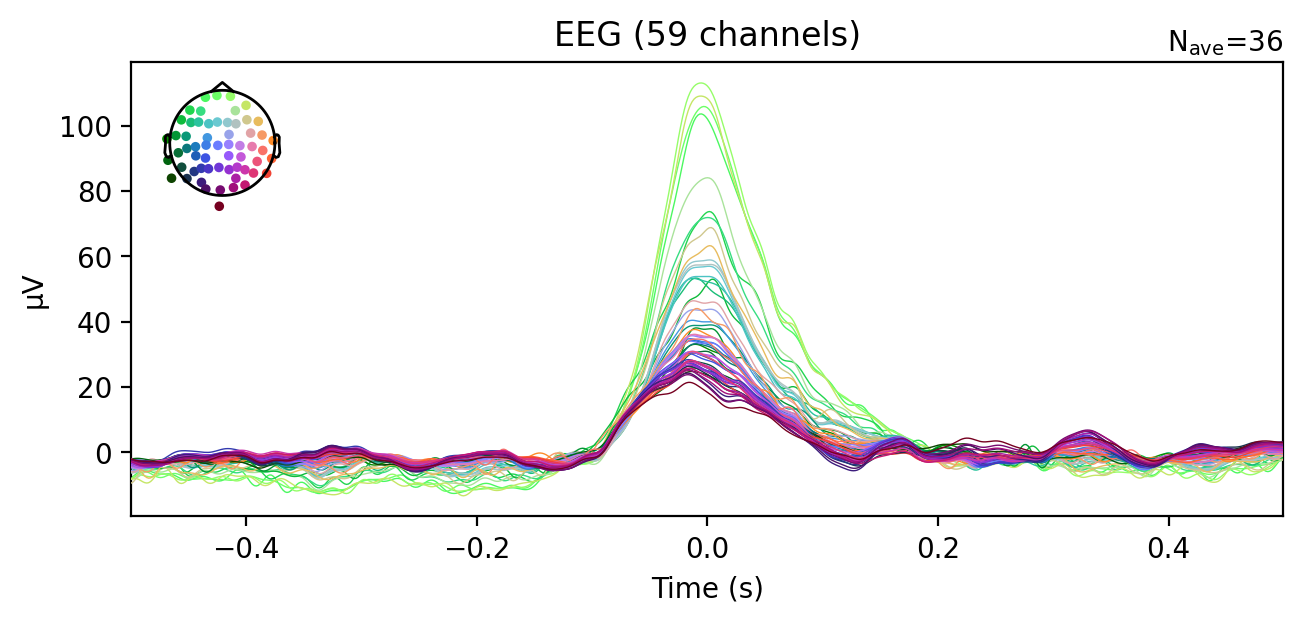

In [24]:
from mne.preprocessing import create_eog_epochs

# Set parameters for creating epochs
reject = {'eeg': 2e-4}
picks = pick_types(data_filtered.info, meg=False, eeg=True, eog=True, stim=False)

# Create EOG epochs:
eog_epochs = create_eog_epochs(data_filtered, picks=picks,
                               ch_name="EOG 061", reject=reject)

# Compute average eyeblink and plot:
eog_average = eog_epochs.average()
eog_average.plot()

Next we detect EOG related components using correlation. Detection is based on Pearson correlation between the filtered data and the filtered EOG channel. Thresholding is based on adaptive z-scoring. The above threshold components will be masked and the z-score will be recomputed until no supra-threshold component remains. Use the fitted ICA object's `.find_bads_eog()` method to obtain the EEG IC that corresponds to eyeblinks as well as the correlation scores. Use the fitted ICA object's `.plot_scores()` method to plot the scores.

In [21]:
# Detect EOG components find_bads_eog:
eog_inds, scores = ica.find_bads_eog(eog_epochs)

# Plot correlation scores:
ica.plot_scores(scores, exclude=eog_inds);

Using EOG channel: EOG 061


We can also inspect the ICA-based source timecourse within the time window of our EOG average. Use the fitted ICA object's `.plot_sources()` method with the average EOG epochs to visualize all of the sources during eyeblinks. One component should pop out!

In [26]:
# Plot sources:
ica.plot_sources(eog_average);

We can take a look at the properties of that component, now using the data epoched with respect to EOG events. Use `plot_properties` to visualize the the EOG epochs, specifically focusing on the EOG IC identified by `find_bads_eog`.

In [27]:
# Plot problematic IC properties during eyeblink epochs:
ica.plot_properties(eog_epochs, picks=eog_inds, psd_args={'fmax': 40.}, image_args={'sigma': 1.});

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
36 matching events found
No baseline correction applied
0 projection items activated


Now let’s see how we would modify our signals if we removed this component from the data. Use the fitted ICA object's `.plot_overlay` function specifying the averaged EOG epoch and set `exclude` to the index of the IC corresponding to eyeblinks.

In [29]:
# Plot overlay of before and after eyeblink IC removal:
ica.plot_overlay(eog_average, exclude=eog_inds);

Applying ICA to Evoked instance
    Transforming to ICA space (25 components)
    Zeroing out 1 ICA component
    Projecting back using 59 PCA components


To register this component as a bad one to be remove, use the `ica.exclude` attribute. This is a simple Python list; i.e. append the problematic IC index to `exclude` attribute of the fitted ICA object.

In [31]:
ica.exclude

[0]

In [30]:
# Add eyeblink IC index to exclude:
ica.exclude.extend(eog_inds)

Note that nothing is yet removed from the raw data. To remove the effects of the rejected components, the `.apply()` method of the fitted ICA object must be called on the data. This will reconstruct the data without any ICs in the `exclude` list. We apply the ICA transformation to a copy of the original raw data.

In [32]:
# Copy filtered raw data
data_ica = data_filtered.copy()

# Apply ICA decomposition and transformation:
ica.apply(data_ica)

# Save preprocessed data:
ica_fn = 'sub-01_task-audvis_preproc_raw.fif'
data_ica.save(ica_fn, overwrite=True)

Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 1 ICA component
    Projecting back using 59 PCA components
Overwriting existing file.
Writing /Users/snastase/Work/neu502b-2024/neu502b-2024/elec-00/sub-01_task-audvis_preproc_raw.fif
Closing /Users/snastase/Work/neu502b-2024/neu502b-2024/elec-00/sub-01_task-audvis_preproc_raw.fif
[done]


Finally, interactive re-visualize the preprocessed EEG data using the data's `.plot()` method.

In [35]:
# Interactively plot preprocessed data:
%matplotlib osx

data_ica.plot();